# In this notebook we use our cluster assignments to make song recommendations

In this notebook, we analyze the clusters in two ways:
-  Playlist Generation
-  Cluster Summary Metrics


**Playlist Generation:**
We determine the top x songs for each cluster for both clustering methods. We define 'top' based on the number of plays of a song for users within that cluster. We also look at the global number of plays of that song to get a rough measure of if the ranking looks reasonable compared to the entire dataset

Then we select an arbitrary user and the top x songs for that user. We find the cluster ID (for both kmeans and HDBSCAN models respectively) that the user belongs to. And then we compare the top x songs of the user with the top x songs of the clusters, and then also compare the two clusters with each other. Afterward, we also look at the artists, years and genre labels of those top x songs and do a similar comparison.

We also inspect the attributes for the top x songs, both the ones the user already listens to and the ones that are recommended.


**Cluster Summary Metrics**

We aggregate the total plays and total track time for the clusters. Then we take the mean for the aggregates based on the number of unique users in that cluster and visualize the overall spread of the clusters.

We also look at the distribution of unique users and user-interactions across the various clusters for both clustering methods

## Load data

In [1]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns

RANDOM_STATE = 42

In [2]:
# If using a local environment
data_path = "data/"

In [3]:
# # If using a collab environment
# from google.colab import drive
#
# drive.mount('/content/drive')
#
# data_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/"

In [4]:
users_with_clusters_path = data_path + "users_clusters_500k_df.parquet"
songs_path = data_path + "songs_df_cleaned.parquet"
track_metadata_path = data_path + "track_metadata.db"

In [5]:
track_metadata_conn = sqlite3.connect(track_metadata_path)
track_metadata_sql_query = "SELECT * FROM songs"
song_metadata_df = pd.read_sql_query(
    track_metadata_sql_query,
    track_metadata_conn
).drop_duplicates(subset=['song_id'])
track_metadata_conn.close()

In [6]:
# Polars is faster at loading large datasets
users_polars_df = pl.read_parquet(users_with_clusters_path)
songs_polars_df = pl.read_parquet(songs_path)

In [7]:
# This conversion can take 51s on regular ram, 21 seconds on high-ram mode
users_df = users_polars_df.to_pandas(use_pyarrow_extension_array=True)
songs_df = songs_polars_df.to_pandas(use_pyarrow_extension_array=True)

In [8]:
len(users_df)

503333

In [9]:
users_df.head(5)

,user_id,hdb_cluster,kmeans_cluster
0,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,120,20
1,0000267bde1b3a70ea75cf2b2d216cb828e3202b,97,19
2,00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e,-1,1
3,00007ed2509128dcdd74ea3aac2363e24e9dc06b,79,1
4,0000bb531aaa657c932988bc2f7fd7fc1b2050ec,42,25


In [10]:
len(songs_df)

26102714

In [11]:
songs_df.head()

,user_id,song_id,plays,track_id,title,release,duration,artist_id,artist_name,artist_familiarity,artist_hotttnesss,year,majority_genre,minority_genre,tot_track_time
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Nothing from Nothing,To Die For,153.59955,ARHYUI71187FB48366,Billy Preston,0.580555,0.482492,1974,RnB,<NA>,153.59955
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Entre Dos Aguas,Flamenco Para Niños,358.24281,ARC1SF21187FB51D0F,Paco De Lucia,0.633119,0.417718,1976,Electronic,Metal,716.48562
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Under Cold Blue Stars,Under Cold Blue Stars,266.34404,ARMS97V1187B99DD98,Josh Rouse,0.675339,0.509058,2002,Rock,<NA>,266.34404
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,TRPLAXZ128F4292406,12 segundos de oscuridad,10 + Downloaded,246.83057,AR1BQ6Y1187B98D586,Jorge Drexler,0.641037,0.412069,2006,Latin,Pop,493.66114
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRHNCIR128F42334A5,Stronger,Graduation,311.84934,ARRH63Y1187FB47783,Kanye West,0.877214,1.082503,2007,Rap,<NA>,311.84934


## Playlist Generation

In [12]:
users_songs_clusters = pd.merge(songs_df, users_df, on='user_id')
users_cols = ['user_id', 'song_id', 'plays', 'title', 'release', 'artist_name', 'artist_id', 'duration', 'year',
              'majority_genre', 'kmeans_cluster', 'hdb_cluster', 'tot_track_time']

users_songs_clusters = users_songs_clusters[
    users_cols]
global_plays = users_songs_clusters.groupby('song_id')['plays'].sum().reset_index(name='global_plays')
users_songs_clusters = users_songs_clusters.merge(global_plays, on='song_id')

In [13]:
users_songs_clusters.head(1000)

,user_id,song_id,plays,title,release,artist_name,artist_id,duration,year,majority_genre,kmeans_cluster,hdb_cluster,tot_track_time,global_plays
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,Nothing from Nothing,To Die For,Billy Preston,ARHYUI71187FB48366,153.59955,1974,RnB,14,144,153.59955,1164
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,ARC1SF21187FB51D0F,358.24281,1976,Electronic,14,144,716.48562,4088
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,Under Cold Blue Stars,Under Cold Blue Stars,Josh Rouse,ARMS97V1187B99DD98,266.34404,2002,Rock,14,144,266.34404,396
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,12 segundos de oscuridad,10 + Downloaded,Jorge Drexler,AR1BQ6Y1187B98D586,246.83057,2006,Latin,14,144,493.66114,1480
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,ARRH63Y1187FB47783,311.84934,2007,Rap,14,144,311.84934,28802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,ca80fbb6d0deb3cae53763099e2cae7306f005ec,SOJBLSL12AC468E28E,2,Movin' On,Vagabond Lullabies,Po' Girl,AREFZF31187B998A93,169.69098,2004,Folk,25,-1,339.38196,47
996,ca80fbb6d0deb3cae53763099e2cae7306f005ec,SOKAQBY12AB0185614,1,Beautiful Stranger,Celebration,Madonna,ARBEOHF1187B9B044D,260.75383,1999,Pop,25,-1,260.75383,11453
997,ca80fbb6d0deb3cae53763099e2cae7306f005ec,SOKFWUO12A8C1445BB,2,Ain't Life Sweet,Home To You,Po' Girl,AREFZF31187B998A93,411.19302,2007,Folk,25,-1,822.38604,13
998,ca80fbb6d0deb3cae53763099e2cae7306f005ec,SOKLADX12A8C13AA37,2,Still On My Brain,Justified,Justin Timberlake,ARWK5QH1187B9A9B7F,275.66975,2002,RnB,25,-1,551.3395,2948


In [14]:
# Extract metadata once (fastest way to keep columns without slowing down groupby)
meta_cols = ['song_id', 'global_plays', 'title', 'release', 'artist_name', 'artist_id', 'duration', 'year',
             'majority_genre', 'tot_track_time']
song_meta = users_songs_clusters[meta_cols].drop_duplicates('song_id')

# KMeans: Group by IDs (fast), sum, sort, take top 8, then restore metadata
songs_per_kmeans_cluster = (
    users_songs_clusters.groupby(['kmeans_cluster', 'song_id'], as_index=False)['plays'].sum()
    .sort_values(['kmeans_cluster', 'plays'], ascending=[True, False])
    .groupby('kmeans_cluster').head(8)
    .merge(song_meta, on='song_id')
)

# HDBSCAN: Group by IDs (fast), sum, sort, take top 8, then restore metadata
songs_per_hdb_cluster = (
    users_songs_clusters.groupby(['hdb_cluster', 'song_id'], as_index=False)['plays'].sum()
    .sort_values(['hdb_cluster', 'plays'], ascending=[True, False])
    .groupby('hdb_cluster').head(8)
    .merge(song_meta, on='song_id')
)

print("Top 20 KMeans Songs:")
display(songs_per_kmeans_cluster.head(100))
print("\nTop 20 HDBSCAN Songs:")
display(songs_per_hdb_cluster.head())

Top 20 KMeans Songs:


,kmeans_cluster,song_id,plays,global_plays,title,release,artist_name,artist_id,duration,year,majority_genre,tot_track_time
0,0,SOAUWYT12A81C206F1,27302,288933,Undo,Vespertine Live,Björk,ARAOQ5T1187FB435AB,348.57751,2001,Rock,697.15502
1,0,SOBONKR12A58A7A7E0,11509,330955,You're The One,If There Was A Way,Dwight Yoakam,AR5E44Z1187B9A1D74,239.3073,1990,Country,478.6146
2,0,SOSXLTC12AF72A7F54,9947,238653,Revelry,Only By The Night,Kings Of Leon,ARF2EHS1187B994F4E,201.79546,2008,Rock,403.59092
3,0,SONYKOW12AB01849C9,4537,164866,Secrets,Waking Up,OneRepublic,AR73S4G1187B9A03C2,224.67873,2009,Rock,449.35746
4,0,SOUDLVN12AAFF43658,4470,56204,Make Love To Your Mind,Playlist: The Very Best Of Bill Withers,Bill Withers,ARBPIT91187B9ABC56,383.73832,1975,RnB,383.73832
...,...,...,...,...,...,...,...,...,...,...,...,...
95,11,SOTWNDJ12A8C143984,3136,98216,Marry Me,Save Me_ San Francisco,Train,ARICCZI1187B9AEBB3,205.45261,2009,Pop,205.45261
96,12,SOBONKR12A58A7A7E0,45474,330955,You're The One,If There Was A Way,Dwight Yoakam,AR5E44Z1187B9A1D74,239.3073,1990,Country,478.6146
97,12,SOSXLTC12AF72A7F54,31030,238653,Revelry,Only By The Night,Kings Of Leon,ARF2EHS1187B994F4E,201.79546,2008,Rock,403.59092
98,12,SOAUWYT12A81C206F1,28294,288933,Undo,Vespertine Live,Björk,ARAOQ5T1187FB435AB,348.57751,2001,Rock,697.15502



Top 20 HDBSCAN Songs:


,hdb_cluster,song_id,plays,global_plays,title,release,artist_name,artist_id,duration,year,majority_genre,tot_track_time
0,-1,SOBONKR12A58A7A7E0,110882,330955,You're The One,If There Was A Way,Dwight Yoakam,AR5E44Z1187B9A1D74,239.3073,1990,Country,478.6146
1,-1,SOAUWYT12A81C206F1,100918,288933,Undo,Vespertine Live,Björk,ARAOQ5T1187FB435AB,348.57751,2001,Rock,697.15502
2,-1,SOSXLTC12AF72A7F54,77256,238653,Revelry,Only By The Night,Kings Of Leon,ARF2EHS1187B994F4E,201.79546,2008,Rock,403.59092
3,-1,SONYKOW12AB01849C9,52088,164866,Secrets,Waking Up,OneRepublic,AR73S4G1187B9A03C2,224.67873,2009,Rock,449.35746
4,-1,SOFLJQZ12A6D4FADA6,42588,97474,Tive Sim,Nova Bis-Cartola,Cartola,ARRYVEO1187B98B5F5,127.242,1974,Latin,127.242


Select an arbitrary user to generate a playlist of 8 songs.

In [15]:
u_id = '5af2527350515c63db37c88f9e71c76deb9819a9'
# u_id = "0afaa5d9d04bf85af720fe8cc566a41ca3e41c97"
u_df = users_songs_clusters[users_songs_clusters['user_id'] == u_id].sort_values(by='plays', ascending=False).head(8)
hdb_cid = u_df['hdb_cluster'].values[0]
km_cid = u_df['kmeans_cluster'].values[0]

hdb_df = songs_per_hdb_cluster[songs_per_hdb_cluster['hdb_cluster'] == hdb_cid]
km_df = songs_per_kmeans_cluster[songs_per_kmeans_cluster['kmeans_cluster'] == km_cid]

Inspecting the data for the few songs for the user and the clusters its assigned to

Text(0.5, 1.02, 'Top x Songs for User: 5af2527350515c63db37c88f9e71c76deb9819a9')

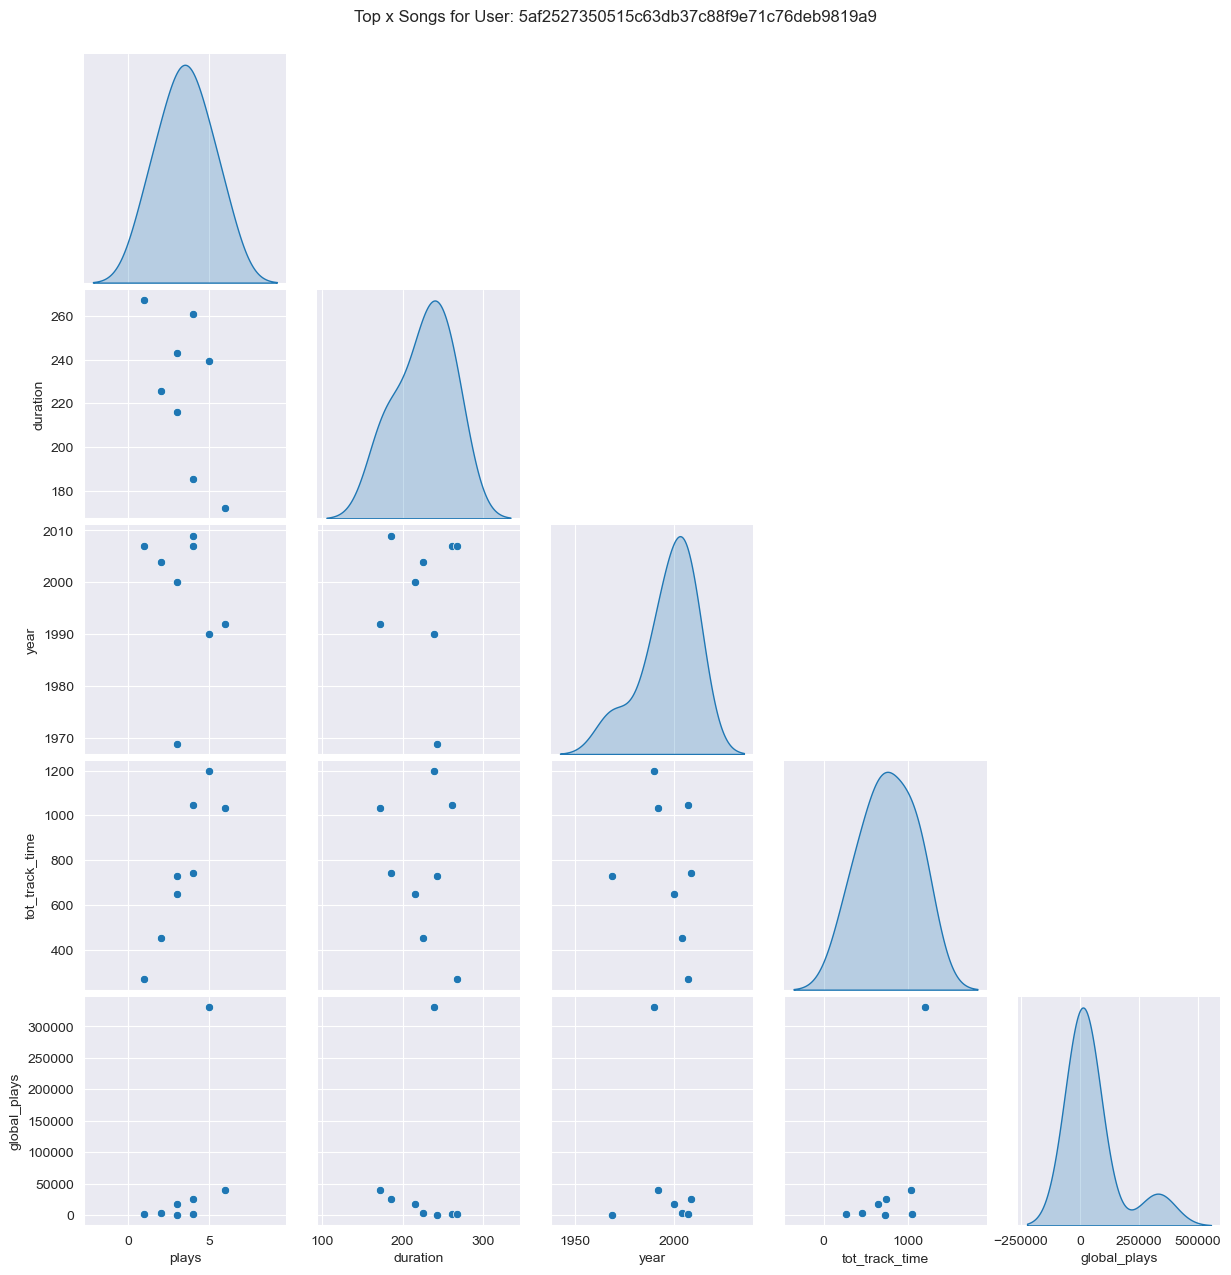

In [16]:
sns.pairplot(u_df.drop(columns=['kmeans_cluster', 'hdb_cluster']), corner=True, diag_kind='kde')
plt.suptitle(f'Top x Songs for User: {u_id}', y=1.02)

Text(0.5, 1.02, 'Top x Songs for KMeans Cluster ID: 5')

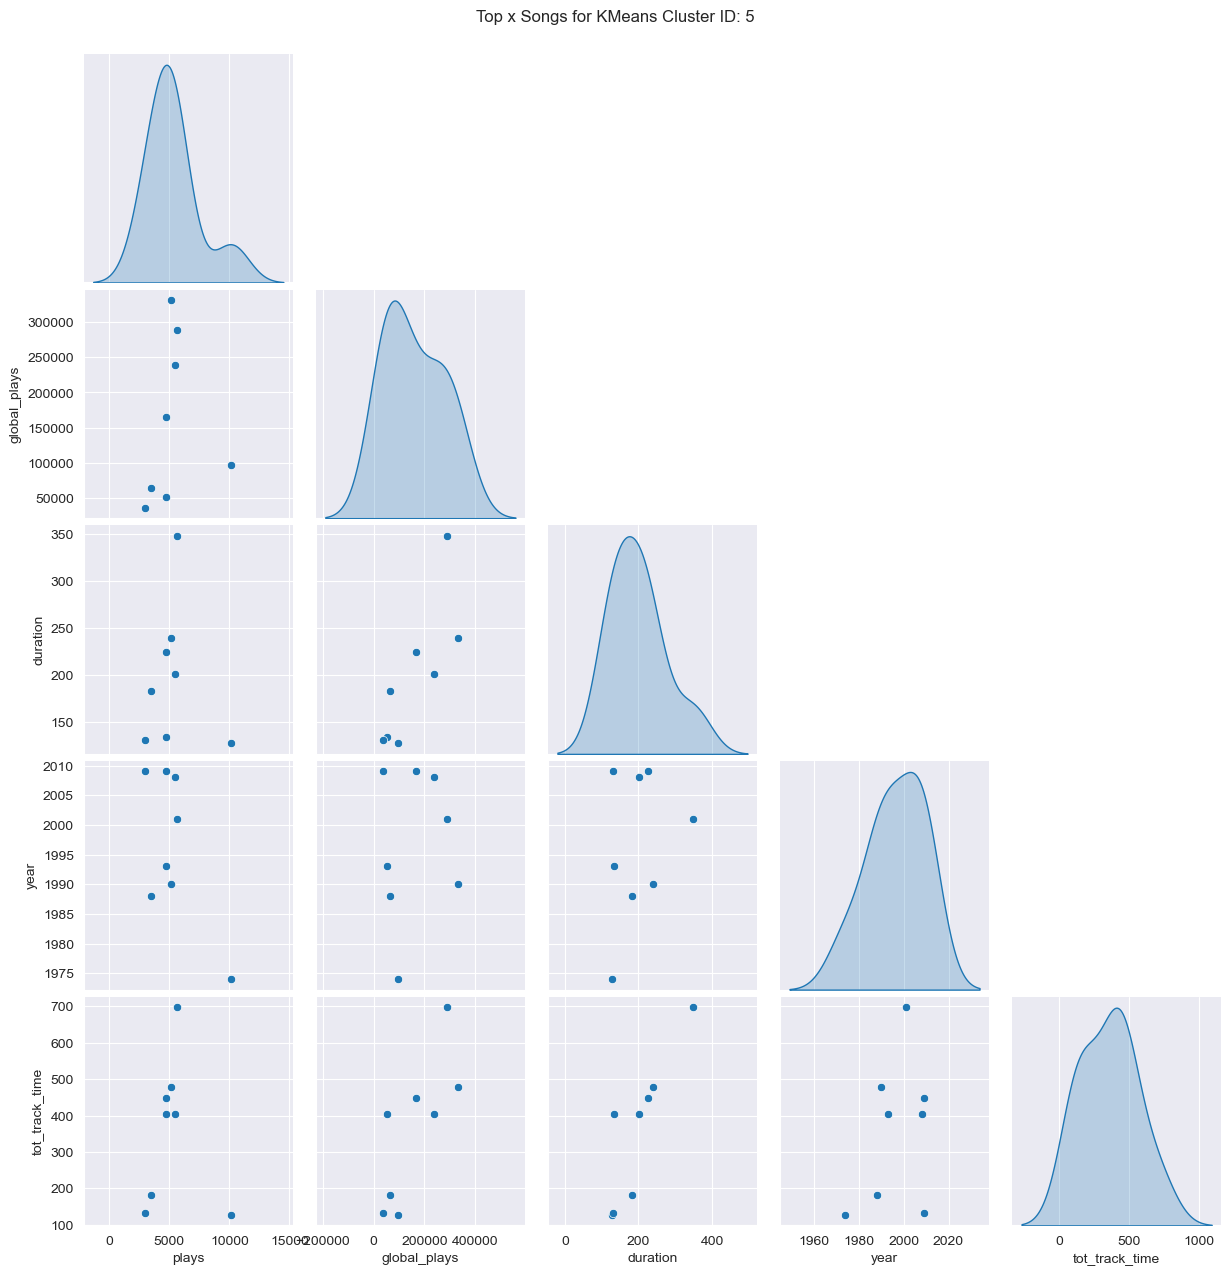

In [17]:
sns.pairplot(km_df.drop(columns='kmeans_cluster'), corner=True, diag_kind='kde')
plt.suptitle(f'Top x Songs for KMeans Cluster ID: {km_cid}', y=1.02)

Text(0.5, 1.02, 'Top x Songs for HDBSCAN Cluster ID: 14')

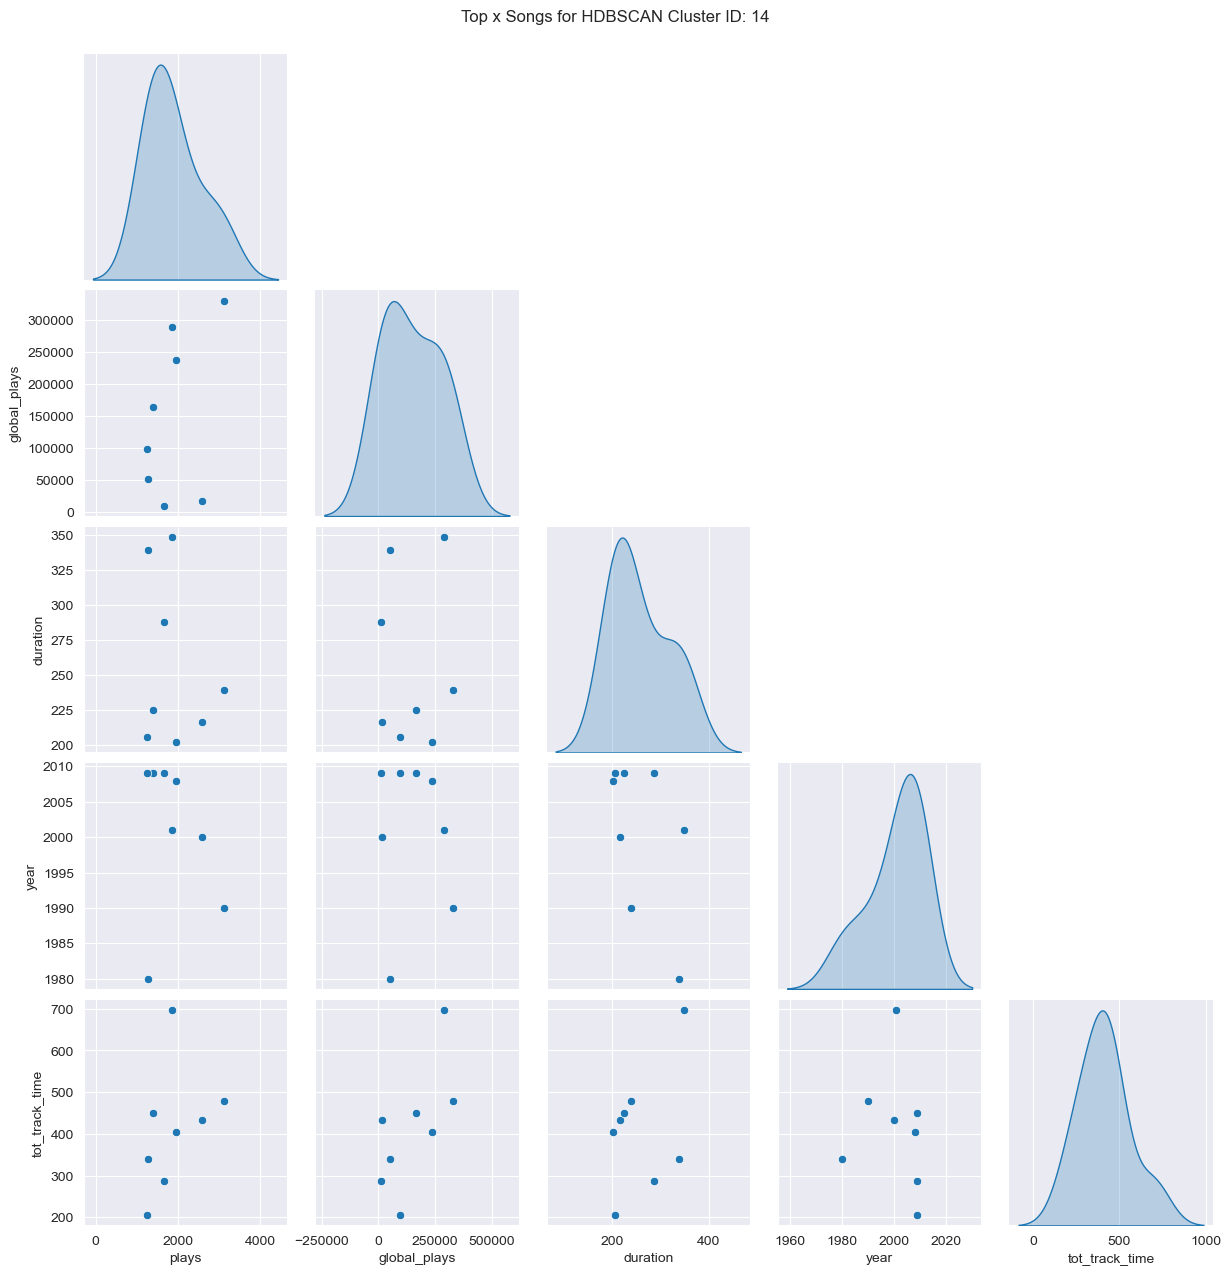

In [18]:
sns.pairplot(hdb_df.drop(columns='hdb_cluster'), corner=True, diag_kind='kde')
plt.suptitle(f'Top x Songs for HDBSCAN Cluster ID: {hdb_cid}', y=1.02)

Generating songs for a user

In [19]:
print(f"top 8 songs for  user {u_id}")
u_df[['title', 'release', 'artist_name', 'majority_genre', 'year', 'plays', 'global_plays']].head(8)

top 8 songs for  user 5af2527350515c63db37c88f9e71c76deb9819a9


,title,release,artist_name,majority_genre,year,plays,global_plays
2275866,The Maestro,Check Your Head,Beastie Boys,Rap,1992,6,39489
2275852,You're The One,If There Was A Way,Dwight Yoakam,Country,1990,5,330955
2275858,I'm Not Calling You A Liar,Lungs,Florence + The Machine,Rock,2009,4,26527
2275865,Far Far,Yael Naïm,Yael Naïm,Pop,2007,4,2504
2275862,And When I Die,Collections,Blood_ Sweat & Tears,Rock,1969,3,580
2275873,Follow Me (Explicit LP Version),Double Wide,Uncle Kracker,Rock,2000,3,17482
2275860,Ya Nada Queda,Ultimate Hits Latino,Kudai,Latin,2004,2,3111
2275848,Toxic,Yael Naïm,Yael Naïm,Pop,2007,1,2160


In [20]:
print(f"top 8 songs for kmeans cluster {km_cid} to which user {u_id} belongs to")
km_df[['title', 'release', 'artist_name', 'majority_genre', 'year', 'plays', 'global_plays']].head(8)

top 8 songs for kmeans cluster 5 to which user 5af2527350515c63db37c88f9e71c76deb9819a9 belongs to


,title,release,artist_name,majority_genre,year,plays,global_plays
40,Tive Sim,Nova Bis-Cartola,Cartola,Latin,1974,10175,97474
41,Undo,Vespertine Live,Björk,Rock,2001,5685,288933
42,Revelry,Only By The Night,Kings Of Leon,Rock,2008,5507,238653
43,You're The One,If There Was A Way,Dwight Yoakam,Country,1990,5131,330955
44,Fuck Kitty,Frumpie One-Piece,Frumpies,Punk,1993,4750,52016
45,Secrets,Waking Up,OneRepublic,Rock,2009,4721,164866
46,16 Candles,16 Candles,The Crests,Rock,1988,3481,64362
47,Kiss With A Fist,Wild Child OST,Florence + The Machine,Pop,2009,2992,36701


In [21]:
print(f"top 8 songs for hdb cluster {hdb_cid} to which user {u_id} belongs to")
hdb_df[['title', 'release', 'artist_name', 'majority_genre', 'year', 'plays', 'global_plays']].head(8)

top 8 songs for hdb cluster 14 to which user 5af2527350515c63db37c88f9e71c76deb9819a9 belongs to


,title,release,artist_name,majority_genre,year,plays,global_plays
120,You're The One,If There Was A Way,Dwight Yoakam,Country,1990,3121,330955
121,Follow Me (Explicit LP Version),Double Wide,Uncle Kracker,Rock,2000,2598,17482
122,Revelry,Only By The Night,Kings Of Leon,Rock,2008,1951,238653
123,Undo,Vespertine Live,Björk,Rock,2001,1856,288933
124,Head Full Of Doubt/Road Full Of Promise,I And Love And You,The Avett Brothers,Rock,2009,1675,10091
125,Secrets,Waking Up,OneRepublic,Rock,2009,1391,164866
126,West One (Shine On Me),The Crack/Grin And Bear It,The Ruts,Punk,1980,1274,52282
127,Marry Me,Save Me_ San Francisco,Train,Pop,2009,1253,98216


In [22]:
total_songs_user = len(u_df)
total_artists_user = len(u_df['artist_name'])
total_genres_user = len(u_df['majority_genre'].dropna())
total_years_user = len(u_df['year'].dropna())

user_hdb_common_songs = set(u_df['song_id']).intersection(set(hdb_df['song_id']))
no_u_hdb_songs = len(user_hdb_common_songs)

user_kmeans_common_songs = set(u_df['song_id']).intersection(set(km_df['song_id']))
no_u_kmeans_songs = len(user_kmeans_common_songs)

kmeans_hdb_common_songs = set(km_df['song_id']).intersection(set(hdb_df['song_id']))
no_kmeans_hdb_songs = len(kmeans_hdb_common_songs)


def get_song_titles(song_ids_set, song_metadata_df):
    return song_metadata_df[song_metadata_df['song_id'].isin(song_ids_set)]['title'].tolist()


user_hdb_common_song_titles = get_song_titles(user_hdb_common_songs, song_meta)
user_kmeans_common_song_titles = get_song_titles(user_kmeans_common_songs, song_meta)
kmeans_hdb_common_song_titles = get_song_titles(kmeans_hdb_common_songs, song_meta)

print(
    f"Common song user-hdb: {user_hdb_common_song_titles} (Count: {no_u_hdb_songs}/{total_songs_user}, Ratio: {no_u_hdb_songs / total_songs_user:.2f})")
print(
    f"Common song user-kmeans: {user_kmeans_common_song_titles} (Count: {no_u_kmeans_songs}/{total_songs_user}, Ratio: {no_u_kmeans_songs / total_songs_user:.2f})")
print(
    f"Common song kmeans-hdb: {kmeans_hdb_common_song_titles} (Count: {no_kmeans_hdb_songs}, Ratio: {no_kmeans_hdb_songs / len(km_df):.2f})")

user_hdb_common_artists = set(u_df['artist_name']).intersection(set(hdb_df['artist_name']))
no_u_hdb_artists = len(user_hdb_common_artists)

user_kmeans_common_artists = set(u_df['artist_name']).intersection(set(km_df['artist_name']))
no_u_kmeans_artists = len(user_kmeans_common_artists)

kmeans_hdb_common_artists = set(km_df['artist_name']).intersection(set(hdb_df['artist_name']))
no_kmeans_hdb_artists = len(kmeans_hdb_common_artists)

print(
    f"\n\nCommon artist user-hdb: {user_hdb_common_artists} (Count: {no_u_hdb_artists}/{total_artists_user}, Ratio: {no_u_hdb_artists / total_artists_user:.2f})")
print(
    f"Common artist user-kmeans: {user_kmeans_common_artists} (Count: {no_u_kmeans_artists}/{total_artists_user}, Ratio: {no_u_kmeans_artists / total_artists_user:.2f})")
print(
    f"Common artist kmeans-hdb: {kmeans_hdb_common_artists} (Count: {no_kmeans_hdb_artists}, Ratio: {no_kmeans_hdb_artists / len(km_df['artist_name']):.2f})")

user_hdb_common_genres = set(u_df['majority_genre'].dropna()).intersection(set(hdb_df['majority_genre'].dropna()))
no_u_hdb_genres = len(user_hdb_common_genres)

user_kmeans_common_genres = set(u_df['majority_genre'].dropna()).intersection(set(km_df['majority_genre'].dropna()))
no_u_kmeans_genres = len(user_kmeans_common_genres)

kmeans_hdb_common_genres = set(km_df['majority_genre'].dropna()).intersection(set(hdb_df['majority_genre'].dropna()))
no_kmeans_hdb_genres = len(kmeans_hdb_common_genres)

print(
    f"\n\nCommon genre user-hdb: {user_hdb_common_genres} (Count: {no_u_hdb_genres}/{total_genres_user}, Ratio: {no_u_hdb_genres / total_genres_user:.2f})")
print(
    f"Common genre user-kmeans: {user_kmeans_common_genres} (Count: {no_u_kmeans_genres}/{total_genres_user}, Ratio: {no_u_kmeans_genres / total_genres_user:.2f})")
print(
    f"Common genre kmeans-hdb: {kmeans_hdb_common_genres} (Count: {no_kmeans_hdb_genres}, Ratio: {no_kmeans_hdb_genres / len(km_df['majority_genre'].dropna()):.2f})")

user_hdb_common_years = set(u_df['year'].dropna()).intersection(set(hdb_df['year'].dropna()))
no_u_hdb_years = len(user_hdb_common_years)

user_kmeans_common_years = set(u_df['year'].dropna()).intersection(set(km_df['year'].dropna()))
no_u_kmeans_years = len(user_kmeans_common_years)

kmeans_hdb_common_years = set(km_df['year'].dropna()).intersection(set(hdb_df['year'].dropna()))
no_kmeans_hdb_years = len(kmeans_hdb_common_years)

print(
    f"\n\nCommon year user-hdb: {user_hdb_common_years} (Count: {no_u_hdb_years}/{total_years_user}, Ratio: {no_u_hdb_years / total_years_user:.2f})")
print(
    f"Common year user-kmeans: {user_kmeans_common_years} (Count: {no_u_kmeans_years}/{total_years_user}, Ratio: {no_u_kmeans_years / total_years_user:.2f})")
print(
    f"Common year kmeans-hdb: {kmeans_hdb_common_years} (Count: {no_kmeans_hdb_years}, Ratio: {no_kmeans_hdb_years / len(km_df['year'].dropna()):.2f})")

Common song user-hdb: ["You're The One", 'Follow Me (Explicit LP Version)'] (Count: 2/8, Ratio: 0.25)
Common song user-kmeans: ["You're The One"] (Count: 1/8, Ratio: 0.12)
Common song kmeans-hdb: ['Undo', "You're The One", 'Secrets', 'Revelry'] (Count: 4, Ratio: 0.50)


Common artist user-hdb: {'Dwight Yoakam', 'Uncle Kracker'} (Count: 2/8, Ratio: 0.25)
Common artist user-kmeans: {'Dwight Yoakam', 'Florence + The Machine'} (Count: 2/8, Ratio: 0.25)
Common artist kmeans-hdb: {'Kings Of Leon', 'Dwight Yoakam', 'OneRepublic', 'Björk'} (Count: 4, Ratio: 0.50)


Common genre user-hdb: {'Country', 'Pop', 'Rock'} (Count: 3/8, Ratio: 0.38)
Common genre user-kmeans: {'Country', 'Latin', 'Pop', 'Rock'} (Count: 4/8, Ratio: 0.50)
Common genre kmeans-hdb: {'Country', 'Pop', 'Rock', 'Punk'} (Count: 4, Ratio: 0.50)


Common year user-hdb: {2000, 2009, 1990} (Count: 3/8, Ratio: 0.38)
Common year user-kmeans: {2009, 1990} (Count: 2/8, Ratio: 0.25)
Common year kmeans-hdb: {2008, 2001, 2009, 1990} (Count

In [23]:
songs_per_kmeans_cluster

,kmeans_cluster,song_id,plays,global_plays,title,release,artist_name,artist_id,duration,year,majority_genre,tot_track_time
0,0,SOAUWYT12A81C206F1,27302,288933,Undo,Vespertine Live,Björk,ARAOQ5T1187FB435AB,348.57751,2001,Rock,697.15502
1,0,SOBONKR12A58A7A7E0,11509,330955,You're The One,If There Was A Way,Dwight Yoakam,AR5E44Z1187B9A1D74,239.3073,1990,Country,478.6146
2,0,SOSXLTC12AF72A7F54,9947,238653,Revelry,Only By The Night,Kings Of Leon,ARF2EHS1187B994F4E,201.79546,2008,Rock,403.59092
3,0,SONYKOW12AB01849C9,4537,164866,Secrets,Waking Up,OneRepublic,AR73S4G1187B9A03C2,224.67873,2009,Rock,449.35746
4,0,SOUDLVN12AAFF43658,4470,56204,Make Love To Your Mind,Playlist: The Very Best Of Bill Withers,Bill Withers,ARBPIT91187B9ABC56,383.73832,1975,RnB,383.73832
...,...,...,...,...,...,...,...,...,...,...,...,...
203,25,SOQGVCS12AF72A078D,1717,35514,Paradise City,Greatest Hits,Guns N' Roses,ARM7EDF1187B9B3FA1,406.17751,1987,Rock,812.35502
204,25,SOBONKR12A58A7A7E0,1697,330955,You're The One,If There Was A Way,Dwight Yoakam,AR5E44Z1187B9A1D74,239.3073,1990,Country,478.6146
205,25,SOGPBAW12A6D4F9F22,1382,47203,Livin' On A Prayer,Cross Road,Bon Jovi,ARDVZTE1187FB5A0A1,250.69669,1986,Rock,250.69669
206,25,SOXQYSC12A6310E908,1369,46436,Bitter Sweet Symphony,Bitter Sweet Symphony,The Verve,AR0L04E1187B9AE90C,360.25424,1997,Pop,360.25424


In [24]:
songs_per_hdb_cluster.head(20)

,hdb_cluster,song_id,plays,global_plays,title,release,artist_name,artist_id,duration,year,majority_genre,tot_track_time
0,-1,SOBONKR12A58A7A7E0,110882,330955,You're The One,If There Was A Way,Dwight Yoakam,AR5E44Z1187B9A1D74,239.3073,1990,Country,478.6146
1,-1,SOAUWYT12A81C206F1,100918,288933,Undo,Vespertine Live,Björk,ARAOQ5T1187FB435AB,348.57751,2001,Rock,697.15502
2,-1,SOSXLTC12AF72A7F54,77256,238653,Revelry,Only By The Night,Kings Of Leon,ARF2EHS1187B994F4E,201.79546,2008,Rock,403.59092
3,-1,SONYKOW12AB01849C9,52088,164866,Secrets,Waking Up,OneRepublic,AR73S4G1187B9A03C2,224.67873,2009,Rock,449.35746
4,-1,SOFLJQZ12A6D4FADA6,42588,97474,Tive Sim,Nova Bis-Cartola,Cartola,ARRYVEO1187B98B5F5,127.242,1974,Latin,127.242
5,-1,SOUFTBI12AB0183F65,40114,120871,Invalid,Fermi Paradox,Tub Ring,ARJFYA51187B9A9EDB,233.69098,2002,Rock,233.69098
6,-1,SOOFYTN12A6D4F9B35,40031,114832,Représente,Fat Come Back,Alliance Ethnik,ARZO9UQ1187FB4D261,252.21179,1999,Rap,252.21179
7,-1,SOTVLQY12A58A798C2,32111,61166,Home,Up From Below,Edward Sharpe & The Magnetic Zeros,ARQEBGJ122E6447D2B,306.31138,2009,Rock,1531.5569
8,0,SOAUWYT12A81C206F1,13929,288933,Undo,Vespertine Live,Björk,ARAOQ5T1187FB435AB,348.57751,2001,Rock,697.15502
9,0,SOBONKR12A58A7A7E0,11443,330955,You're The One,If There Was A Way,Dwight Yoakam,AR5E44Z1187B9A1D74,239.3073,1990,Country,478.6146


## Cluster Evaluation

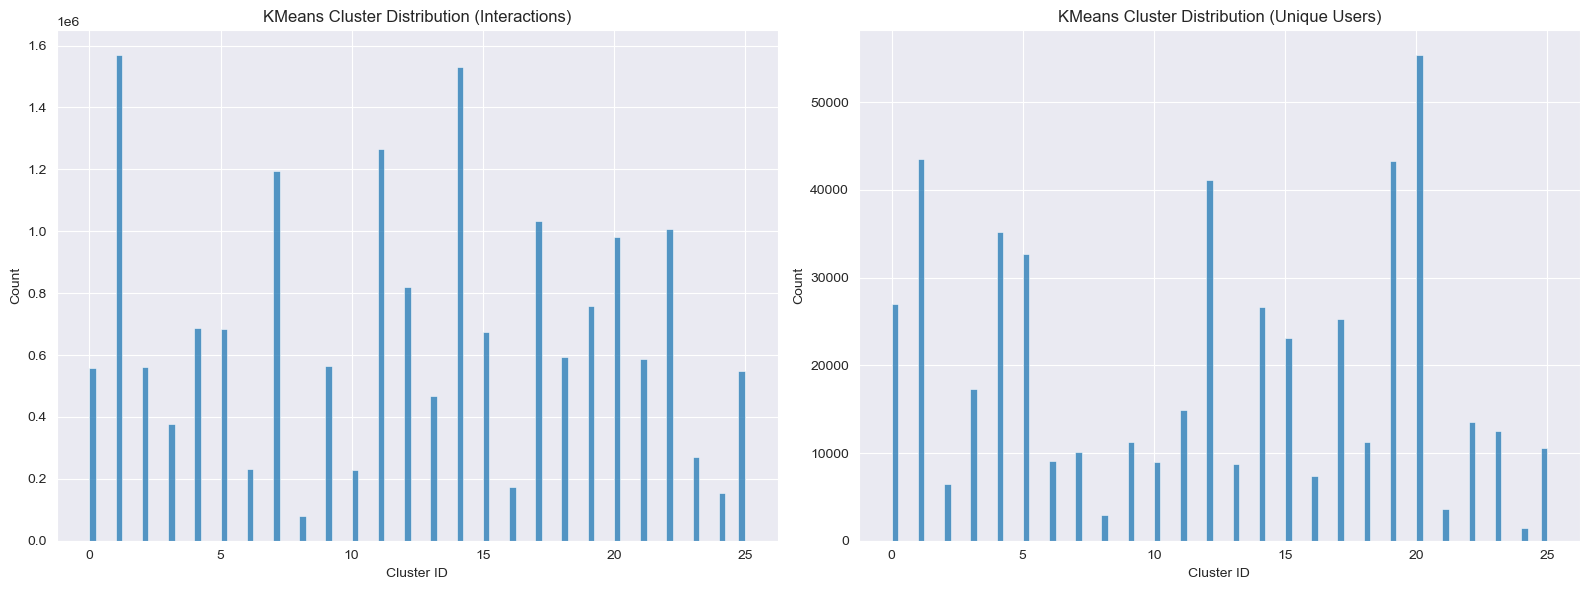

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram for User-Song Interactions (KMeans)
sns.histplot(users_songs_clusters['kmeans_cluster'], bins=100, ax=axes[0])
axes[0].set_title('KMeans Cluster Distribution (Interactions)')
axes[0].set_xlabel('Cluster ID')
axes[0].set_ylabel('Count')

# Histogram for Unique Users (KMeans)
sns.histplot(users_df['kmeans_cluster'], bins=100, ax=axes[1])
axes[1].set_title('KMeans Cluster Distribution (Unique Users)')
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

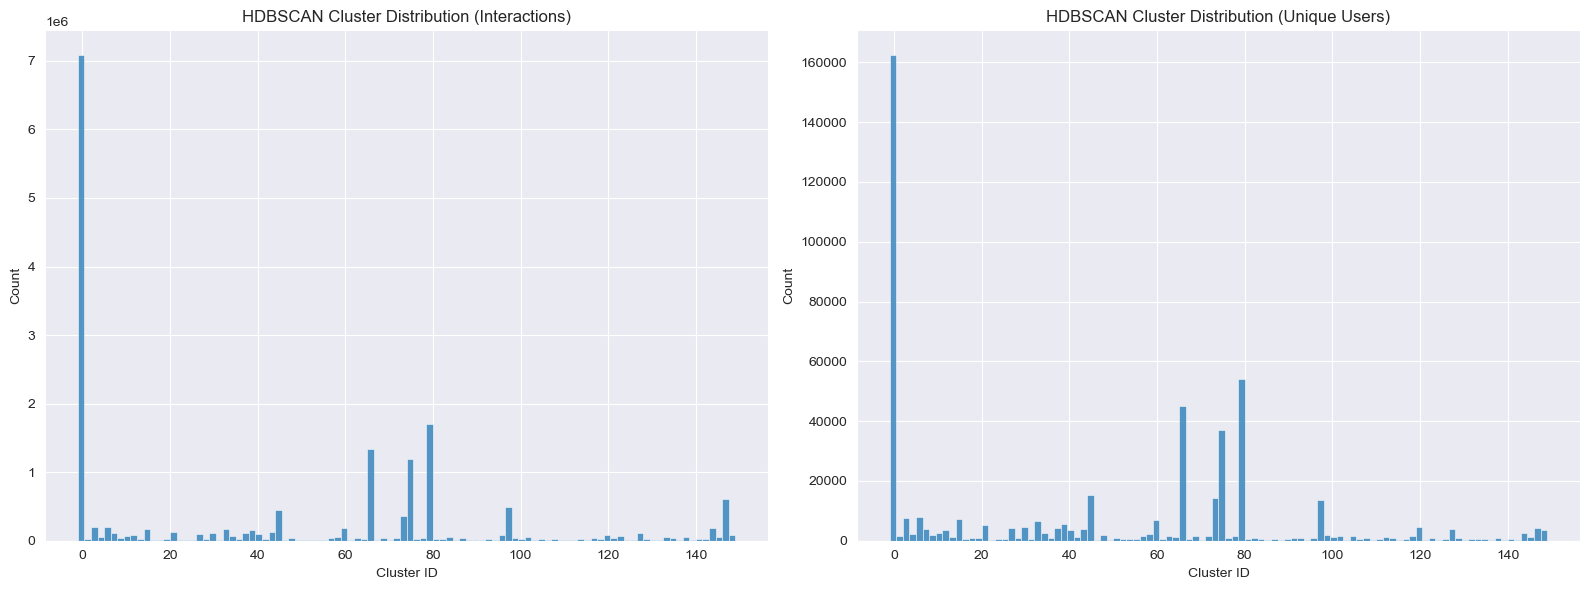

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram for User-Song Interactions (HDBSCAN)
sns.histplot(users_songs_clusters['hdb_cluster'], bins=100, ax=axes[0])
axes[0].set_title('HDBSCAN Cluster Distribution (Interactions)')
axes[0].set_xlabel('Cluster ID')
axes[0].set_ylabel('Count')

# Histogram for Unique Users (HDBSCAN)
sns.histplot(users_df['hdb_cluster'], bins=100, ax=axes[1])
axes[1].set_title('HDBSCAN Cluster Distribution (Unique Users)')
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

We display the summary statistics for all of the clusters and visualize where the means of the clusters are for pairs of each feature. We notice that the clusters are pretty widely spread out for the K Means.

In [27]:
cluster_totals = users_songs_clusters.groupby('kmeans_cluster').agg(
    total_plays=('plays', 'sum'),
    total_track_time=('tot_track_time', 'sum')
)

unique_users_per_cluster = users_songs_clusters.groupby('kmeans_cluster')['user_id'].nunique()
unique_users_per_cluster = users_songs_clusters.groupby('kmeans_cluster')['user_id'].nunique()

avg_plays_per_user = cluster_totals['total_plays'] / unique_users_per_cluster

avg_tot_track_time_per_user = cluster_totals['total_track_time'] / unique_users_per_cluster

k_cluster_summary_df = pd.DataFrame({
    'unique_users': unique_users_per_cluster,
    'total_plays': cluster_totals['total_plays'],
    'total_track_time': cluster_totals['total_track_time'],
    'avg_plays_per_user': avg_plays_per_user,
    'avg_total_track_time_per_user': avg_tot_track_time_per_user
})
display(k_cluster_summary_df)

,unique_users,total_plays,total_track_time,avg_plays_per_user,avg_total_track_time_per_user
kmeans_cluster,,,,,
0,26999,1098597,305781651.41162,40.690285,11325.665818
1,43534,2874317,699234335.26644,66.024647,16061.798485
2,6417,1090560,269342299.4781,169.948574,41973.242867
3,17349,2323405,554636072.09652,133.921552,31969.339564
4,35262,1370285,341715474.18272,38.860104,9690.757024
5,32647,1422783,323628316.31954,43.580819,9912.95728
6,9078,1596968,400025958.8347,175.916281,44065.42838
7,10117,2076075,507021105.31705,205.206583,50115.756184
8,2990,629324,154445349.39476,210.476254,51653.963008


In [28]:
k_cluster_summary_df.describe()

,unique_users,total_plays,total_track_time,avg_plays_per_user,avg_total_track_time_per_user
count,26.000000,26.0,26.0,26.0,26.0
mean,19358.961538,1633904.423077,402118661.719847,119.012098,29401.02533
std,14689.287502,894132.256438,213962488.825803,65.507394,15928.884723
min,1432.000000,263982.0,64196641.93054,33.109523,8119.431838
25%,8993.250000,1092374.5,269814008.10784,56.430104,13713.379626
50%,12977.000000,1396534.0,332671895.25113,104.544375,28307.346868
75%,26909.250000,2074068.0,506535848.084013,174.424354,43542.382002
max,55422.000000,3839992.0,930685240.77365,237.046819,57126.104331


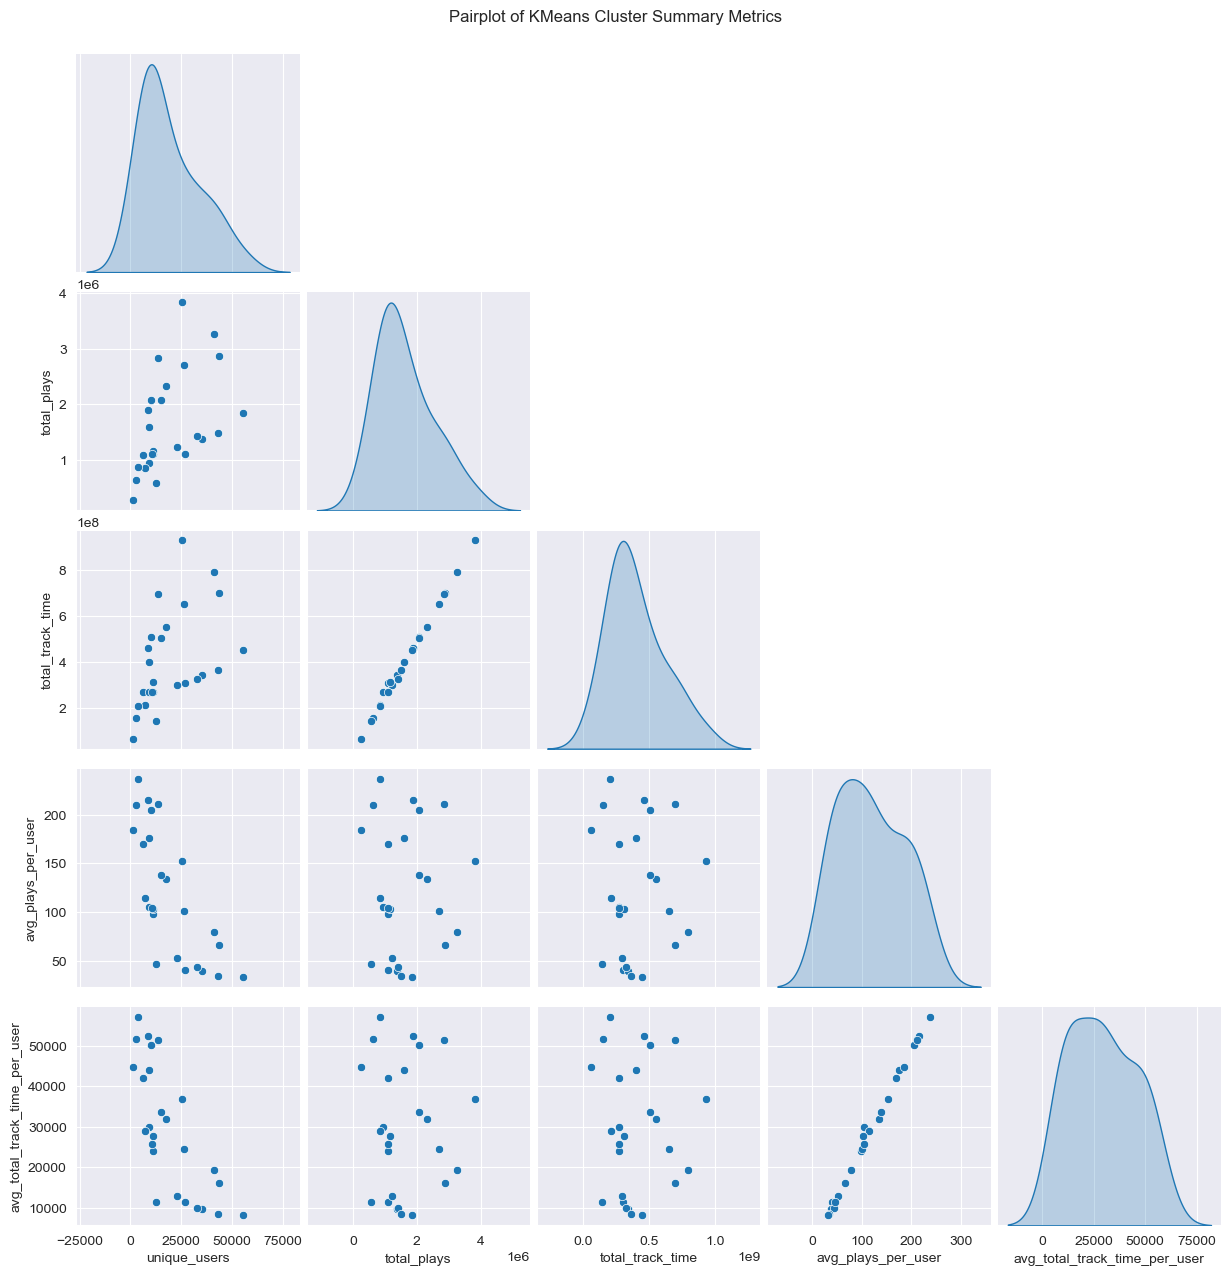

In [29]:
k_cluster_summary_df_plot = k_cluster_summary_df.reset_index()

sns.pairplot(k_cluster_summary_df, corner=True, diag_kind='kde')
plt.suptitle('Pairplot of KMeans Cluster Summary Metrics', y=1.02)
plt.show()

We repeat the above visualization for HDBSCAN clusters and notice that there seems to be a trend of clusters of few users with increasingly high avg plays per user and high average total track times. It appears that the outlier filtering we did leaves a couple thousand medium level power users. Using more attributes for the songs and users as opposed to the aggregate values we used for the users should improve this in the future

In [30]:
h_cluster_totals = users_songs_clusters.groupby('hdb_cluster').agg(
    total_plays=('plays', 'sum'),
    total_track_time=('tot_track_time', 'sum')
)

h_unique_users_per_cluster = users_songs_clusters.groupby('hdb_cluster')['user_id'].nunique()
h_unique_users_per_cluster = users_songs_clusters.groupby('hdb_cluster')['user_id'].nunique()

h_avg_plays_per_user = h_cluster_totals['total_plays'] / h_unique_users_per_cluster

h_avg_tot_track_time_per_user = h_cluster_totals['total_track_time'] / h_unique_users_per_cluster

h_cluster_summary_df = pd.DataFrame({
    'unique_users': h_unique_users_per_cluster,
    'total_plays': h_cluster_totals['total_plays'],
    'total_track_time': h_cluster_totals['total_track_time'],
    'avg_plays_per_user': h_avg_plays_per_user,
    'avg_total_track_time_per_user': h_avg_tot_track_time_per_user
})
display(h_cluster_summary_df)

,unique_users,total_plays,total_track_time,avg_plays_per_user,avg_total_track_time_per_user
hdb_cluster,,,,,
-1,154887,16867456,4146015827.90465,108.90169,26768.003951
0,7678,476358,114474471.63158,62.041938,14909.41282
1,1527,91349,22164750.02033,59.822528,14515.225947
2,6985,462555,105800335.68346,66.221188,15146.791079
3,480,24146,5782873.38484,50.304167,12047.652885
...,...,...,...,...,...
145,1401,96149,22417710.95262,68.628837,16001.221237
146,2003,371975,90859669.3315,185.708937,45361.791978
147,2345,558008,133297418.81085,237.956503,56843.24896


In [31]:
h_cluster_summary_df.describe()

,unique_users,total_plays,total_track_time,avg_plays_per_user,avg_total_track_time_per_user
count,151.000000,151.0,151.0,151.0,151.0
mean,3333.331126,281334.536424,69238974.865669,77.637574,18965.118276
std,14041.386992,1445845.903659,355868825.740746,51.537528,12488.131679
min,203.000000,5246.0,1260815.59374,22.605042,5497.529161
25%,317.500000,20769.0,5187407.099375,46.031527,11239.854478
50%,569.000000,43922.0,10584695.68173,58.335721,14421.267845
75%,1469.500000,99632.5,23428283.18789,81.00822,19560.90006
max,154887.000000,16867456.0,4146015827.90465,237.956503,56843.24896


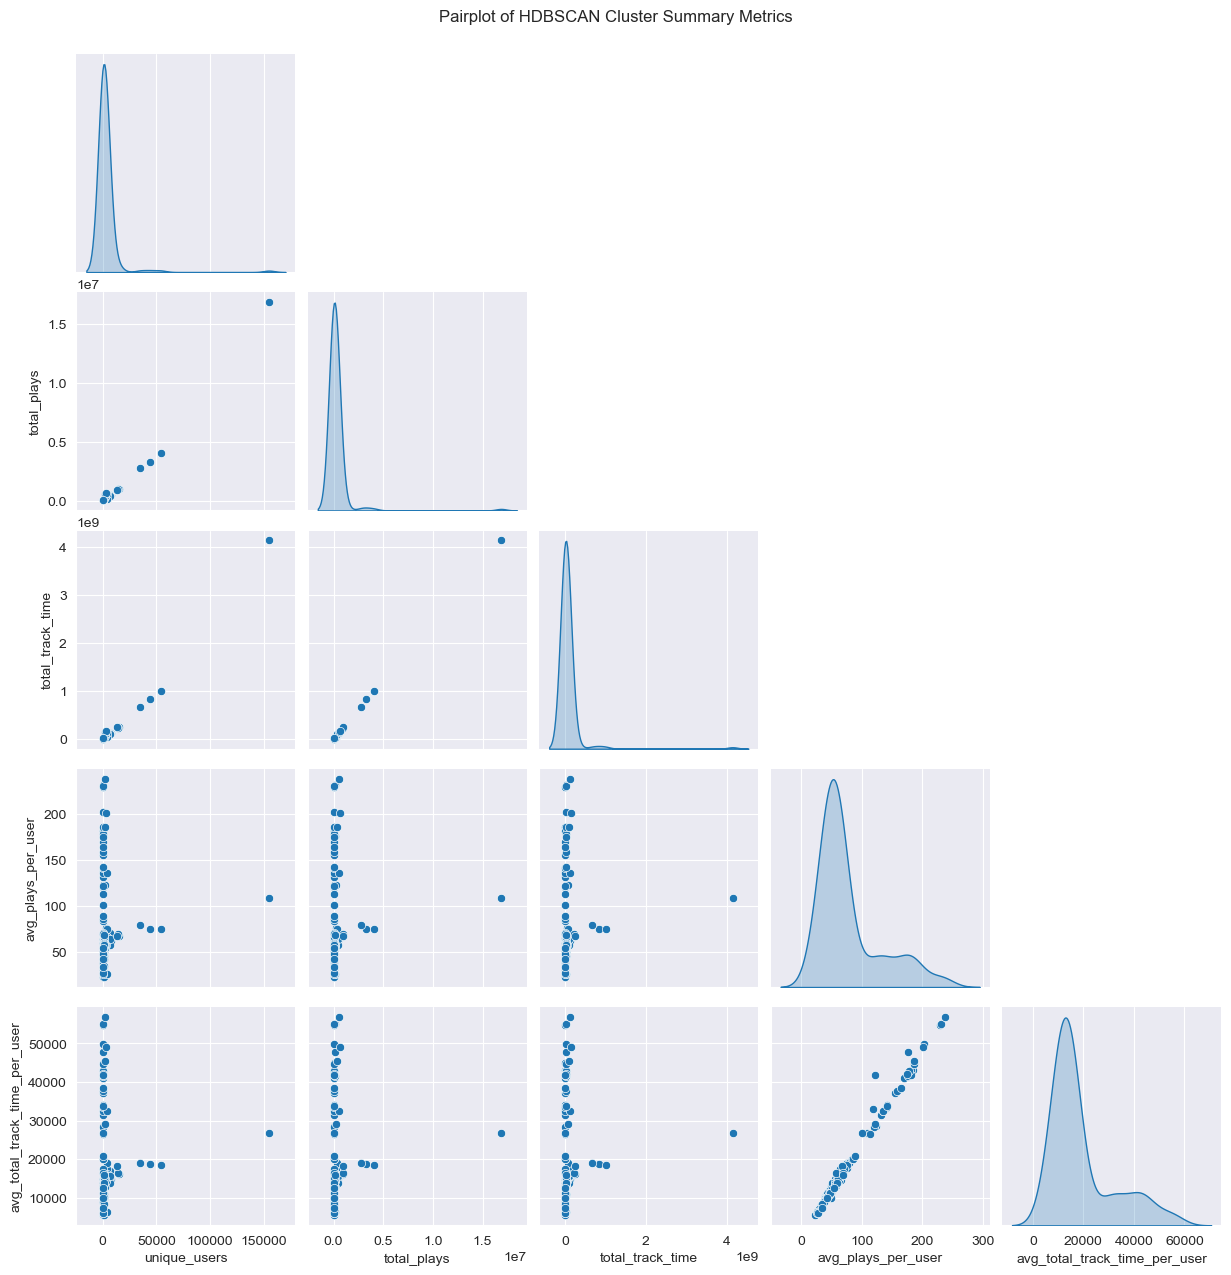

In [32]:
h_cluster_summary_df_plot = h_cluster_summary_df.reset_index()
sns.pairplot(h_cluster_summary_df, corner=True, diag_kind='kde')
plt.suptitle('Pairplot of HDBSCAN Cluster Summary Metrics', y=1.02)
plt.show()

We filter the data by only keeping clusters that are at least as big as the smallest cluster (n unique users ~ 1430) for K Means to inspect closely. We also remove the 'cluster' HDBSCAN labeled as outliers/noise (i.e., cluster id -1)

In [33]:
h_cluster_summary_df_filtered = h_cluster_summary_df.reset_index()
h_cluster_summary_df_filtered = h_cluster_summary_df_filtered[h_cluster_summary_df_filtered['hdb_cluster'] >= 0]
h_cluster_summary_df_filtered = h_cluster_summary_df_filtered[h_cluster_summary_df_filtered['unique_users'] > 1432]
h_cluster_summary_df_filtered

,hdb_cluster,unique_users,total_plays,total_track_time,avg_plays_per_user,avg_total_track_time_per_user
1,0,7678,476358,114474471.63158,62.041938,14909.41282
2,1,1527,91349,22164750.02033,59.822528,14515.225947
3,2,6985,462555,105800335.68346,66.221188,15146.791079
5,4,2247,132609,32861860.89323,59.016021,14624.771203
6,5,7023,495708,118437635.95517,70.583511,16864.251168
8,7,3852,231551,61130219.03817,60.11189,15869.734953
11,10,2571,158360,38751745.41849,61.59471,15072.635324
13,12,2670,201261,47212639.88105,75.378652,17682.63666
15,14,7099,405387,98667054.2336,57.104803,13898.725769
21,20,2679,167025,39215581.99301,62.346025,14638.141841


In [34]:
h_cluster_summary_df_filtered.describe()

,hdb_cluster,unique_users,total_plays,total_track_time,avg_plays_per_user,avg_total_track_time_per_user
count,38.0,38.000000,38.0,38.0,38.0,38.0
mean,54.894737,7631.052632,568341.736842,140195794.562642,77.771386,19013.2177
std,46.124268,11632.355614,878049.102991,218800946.447638,43.017244,10343.660015
min,0.0,1452.000000,50776.0,12231780.17493,26.281923,6503.577572
25%,20.25,2401.500000,158867.0,38867704.56212,60.482595,14820.427452
50%,39.5,3805.500000,265562.0,64912655.44208,64.351689,15700.299982
75%,74.75,6908.500000,490870.5,117446844.874272,73.556413,18055.006496
max,148.0,54090.000000,4049015.0,1006674448.07319,237.956503,56843.24896


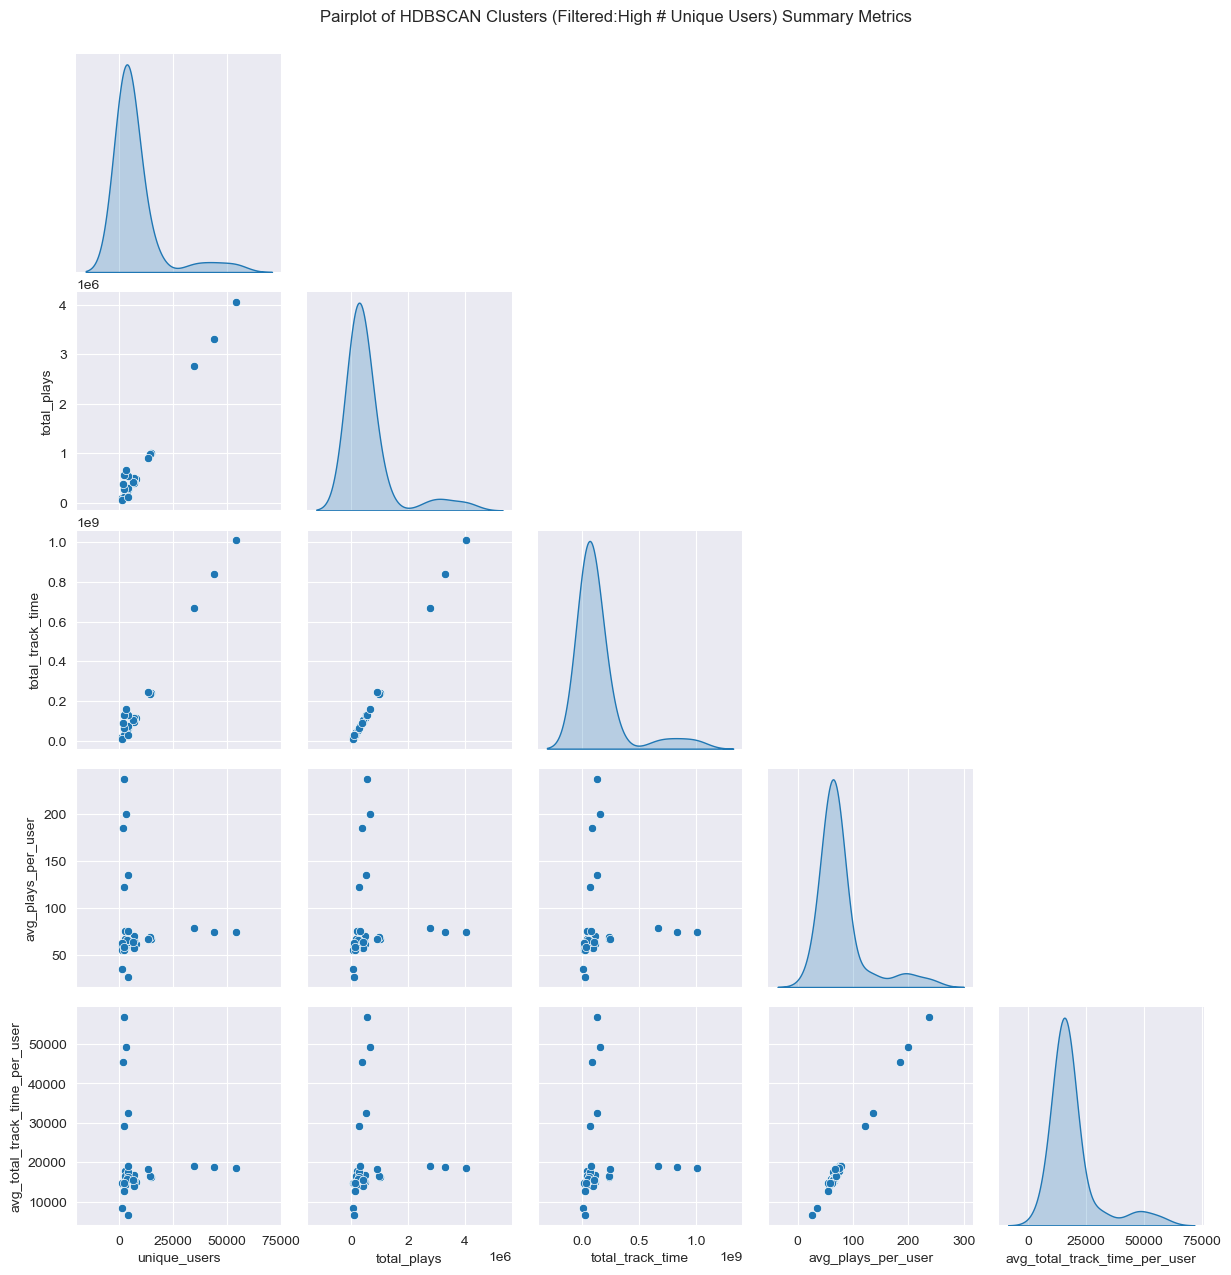

In [35]:
sns.pairplot(h_cluster_summary_df_filtered.drop(columns='hdb_cluster'), corner=True, diag_kind='kde')
plt.suptitle('Pairplot of HDBSCAN Clusters (Filtered:High # Unique Users) Summary Metrics', y=1.02)
plt.show()

Now looking at just the smaller clusters. We want within cluster variance to be small and inter cluster variance to be higher, but it looks like of the clusters are basically the same with slight differences based on the total track time/play count.

In [36]:
h_cluster_summary_df_filtered2 = h_cluster_summary_df.reset_index()
h_cluster_summary_df_filtered2 = h_cluster_summary_df_filtered2[h_cluster_summary_df_filtered2['hdb_cluster'] >= 0]
h_cluster_summary_df_filtered2 = h_cluster_summary_df_filtered2[h_cluster_summary_df_filtered2['unique_users'] < 1432]
h_cluster_summary_df_filtered2

,hdb_cluster,unique_users,total_plays,total_track_time,avg_plays_per_user,avg_total_track_time_per_user
4,3,480,24146,5782873.38484,50.304167,12047.652885
7,6,746,42341,9919527.19768,56.757373,13296.953348
9,8,838,47399,11428440.78749,56.562053,13637.757503
10,9,1117,65161,15585887.23735,58.335721,13953.345781
12,11,994,52023,12342343.66343,52.337022,12416.844732
...,...,...,...,...,...,...
142,141,206,6890,1538651.38583,33.446602,7469.181485
143,142,298,55309,13281183.73694,185.600671,44567.730661
144,143,264,26603,7096416.99563,100.768939,26880.367408
146,145,1401,96149,22417710.95262,68.628837,16001.221237


In [37]:
h_cluster_summary_df_filtered2.describe()

,hdb_cluster,unique_users,total_plays,total_track_time,avg_plays_per_user,avg_total_track_time_per_user
count,112.0,112.000000,112.0,112.0,112.0,112.0
mean,81.151786,522.017857,35866.723214,8764546.280634,77.31303,18879.130207
std,40.599163,328.377858,24486.767593,6021326.307605,54.438966,13210.879925
min,3.0,203.000000,5246.0,1260815.59374,22.605042,5497.529161
25%,49.75,273.000000,15307.25,3797542.859903,43.194058,10851.10132
50%,85.5,380.000000,30866.0,7479678.23855,52.564115,13129.07304
75%,114.25,674.250000,50703.0,12198680.455002,103.850439,26566.303636
max,149.0,1401.000000,120564.0,32757465.70839,230.705263,55105.475768


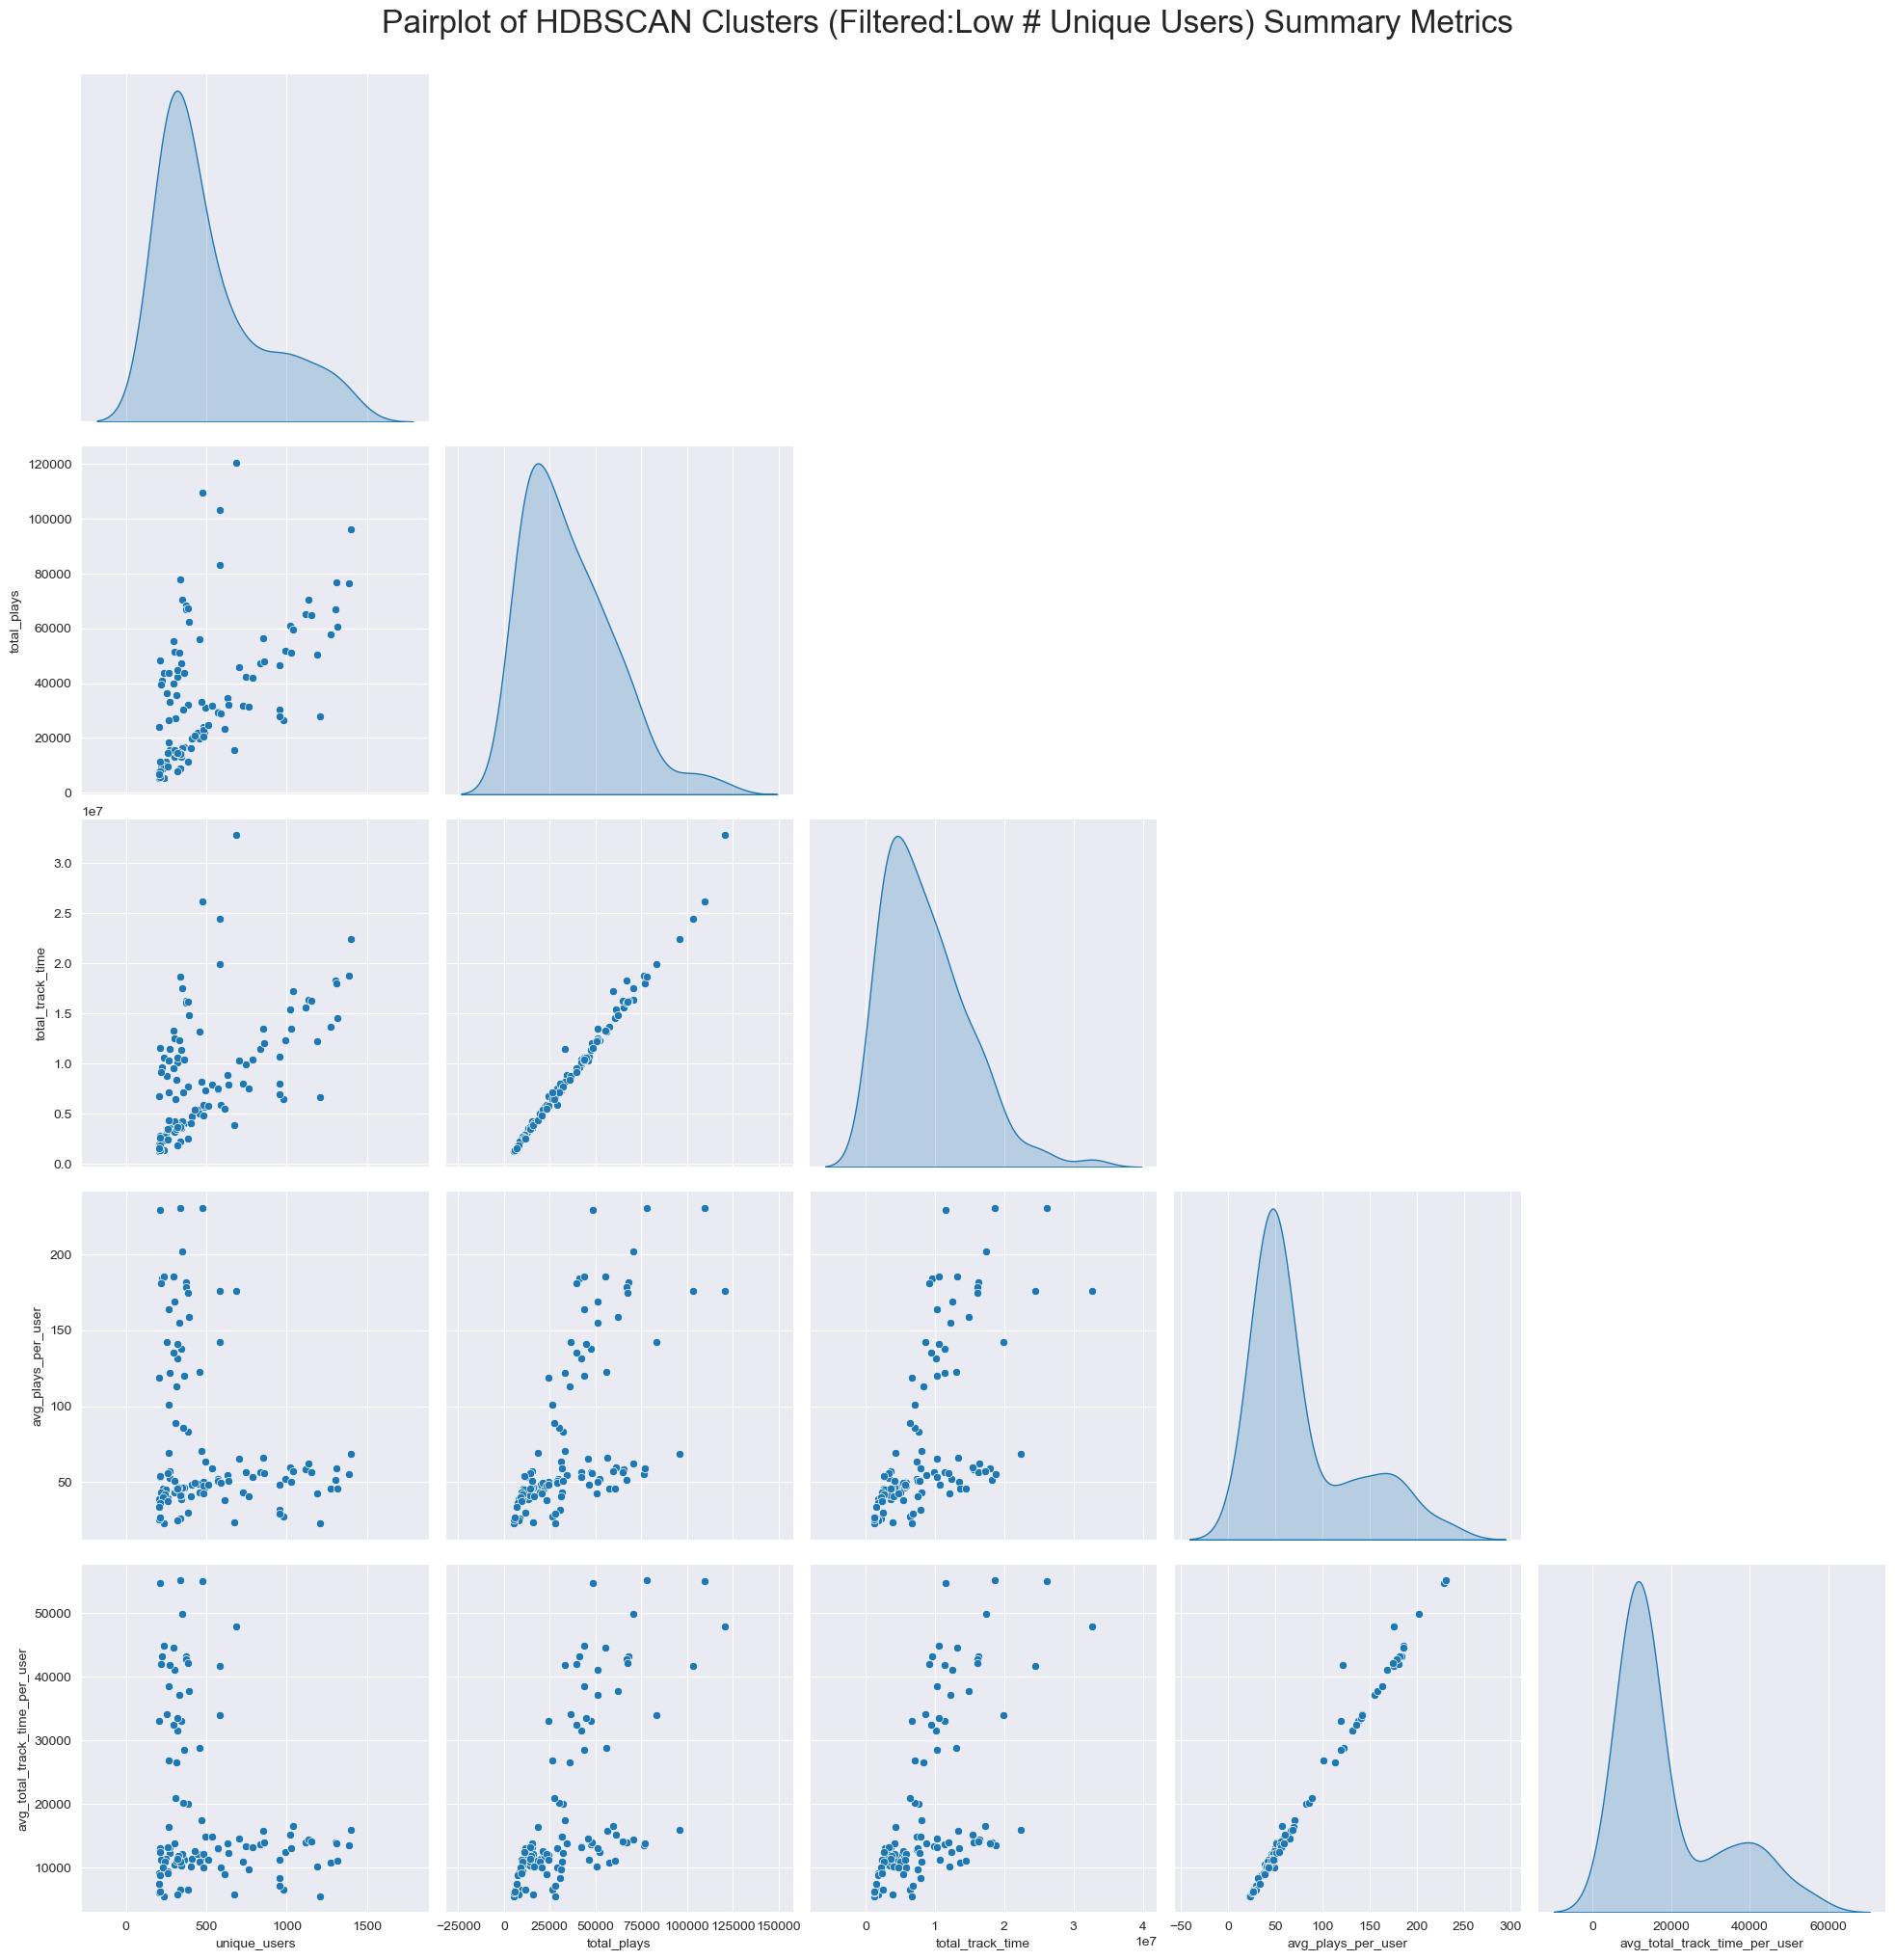

In [38]:
g = sns.pairplot(h_cluster_summary_df_filtered2.drop(columns='hdb_cluster'), corner=True, diag_kind='kde', height=4)

plt.suptitle('Pairplot of HDBSCAN Clusters (Filtered:Low # Unique Users) Summary Metrics', y=1.02, fontsize=24)

plt.show()